Auteur : Wayan CRAIN, Yanis AOUDJIT, Arnaud CHÉRIDI
<br><br>
Rôles :
  * Wayan CRAIN : Partie 2 : Q3 + Q4
  * Yanis AOUDJIT : Partie 2 : Q1 + Q2 + Q Bonus
  * Arnaud CHÉRIDI : Partie 1

<br><br>
Ce notebook a été exécuté dans l'environnement Google Collab

# Projet Deep Learning : Classificateur comme générateur

## Partie 0 : Initialisation : environnement, seed et données

In [ ]:
# Importation des librairies
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [ ]:
# Initialisation de la seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Importation des données
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalisation
X_train, X_test = X_train / 255.0, X_test / 255.0

# Ajouter une dimension pour les canaux (nécessaire pour CNN)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Partie 1 : Entraînement du modèle, ablation, comparaison

### A. Entraînement du modèle

Dans un premier temps nous avons choisi le modèle ci-dessous.

In [ ]:
# Création du modèle
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

1.   Structure générale du modèle
  * Le modèle que nous utilisons est un réseau neuronal convolutif (CNN) utilisé pour classifier des images du dataset MNIST (images de chiffres manuscrits).
2.   Explication des couches
  * conv2d : Cette couche applique une convolution 2D avec 32 filtres de taille $3 \times 3$. Ces filtres apprennent à détecter des motifs, comme les bords ou les textures, dans les images. Le résultat est une carte contenant 32 canaux, où chaque canal met en évidence un motif spécifique détecté par un filtre. Cette étape aide à simplifier les données en mettant en avant les caractéristiques importantes, tout en rendant le modèle plus robuste face aux petites variations.

  * max_pooling2d : Cette couche réduit la taille des images en ne gardant que les valeurs maximales dans chaque région $2 \times 2$. Elle diminue la taille des cartes de caractéristiques de $26 \times 26$ à $13 \times 13$, réduisant ainsi le nombre de pixels par 4. Cette simplification permet de diminuer le coût de calcul et de rendre le modèle plus efficace, tout en capturant des détails essentiels.

  * conv2d_1 : Similaire à la couche conv2d mais avec 64 filtres.

  * max_pooling2d_1 : Identiques à max_pooling2d.

  * flatten : Cette étape aplatie les cartes de caractéristiques en 3D (de dimension $5 \times 5 \times 64$) en un vecteur 1D. Cela permet de préparer les données pour les couches pleinement connectées suivantes.

  * dense : Cette couche connecte chaque élément du vecteur d'entrée (de dimension 1600) à un vecteur de sortie (de dimension 128) grâce à une transformation linéaire, suivie d'une activation ReLU. La transformation est donnée par : $z = W \cdot x + b$ où $W \in \mathbb{R}^{128 \times 1600}$ est la matrice de poids, $x \in \mathbb{R}^{1600}$ est le vecteur d'entrée et $b \in \mathbb{R}^{128}$ le vecteur de biais. Chaque composante $z_i$ subit ensuite l'activation ReLU : $\sigma(z_i) = \max(0, z_i)$.

  * dense_1 : Similaire à la couche dense mais avce une fonction d'activation Softmax qui transforme la sortie en probabilités normalisées sur 10 classes, définie par : $\sigma(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{10} e^{z_j}}$.

3. L'image d'entrée est naturellement en 2D (hauteur et largeur), mais dans un contexte de calcul avec CNN, elle est étendue dans un espace tridimensionnel $\mathbb{R}^{H \times W \times C}$, où H est la hauteur, W la largeur, et C le nombre de canaux de couleur. Dans notre cas, l'image est en niveaux de gris (C = 1), donc elle se situe dans $\mathbb{R}^{28 \times 28 \times 1}$.

4. Nombre de paramètres :\
Pour une couche convolutionnelle, la formule est :\
Paramètres = $(\text{Taille du filtre})^2 \times (\text{Canaux d'entrée}) \times (\text{Nombre de filtres}) + (\text{Nombre de filtres})$
  
  * conv2d : $(3 \times 3) \times 1 \times 32 + 32 = 320$
  * conv2d_1 : $(3 \times 3) \times 32 \times 64 + 64 = 18,496 $

  Pour une couche dense, la formule est :\
Paramètres = $(\text{Neurones d'entrée} + 1) \times (\text{Neurones de sortie})$

  * dense : $(1600 + 1) \times 128 = 204,928$
  * dense_1 : $(128 + 1) \times 10 = 1,290$


5. Le modèle effectue les étapes suivantes :
	*	Extraction des caractéristiques avec des convolutions et max-pooling.
	* Réduction de la taille spatiale tout en augmentant la profondeur des canaux (de 1 à 64).
	* Classification via des couches denses après une mise à plat des caractéristiques extraites.

In [ ]:
# Compilation du modèle
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
# Définir un callback pour sauvegarder le meilleur modèle
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',  # Chemin où le modèle sera sauvegardé
    monitor='val_loss',       # Critère à surveiller
    save_best_only=True,      # Sauvegarde uniquement si le modèle est meilleur
    mode='min'
)

In [ ]:
# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9133 - loss: 0.2805 - val_accuracy: 0.9853 - val_loss: 0.0464
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9861 - loss: 0.0431 - val_accuracy: 0.9885 - val_loss: 0.0331
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9917 - loss: 0.0263 - val_accuracy: 0.9911 - val_loss: 0.0285
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9947 - loss: 0.0183 - val_accuracy: 0.9902 - val_loss: 0.0335
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9960 - loss: 0.0120 - val_accuracy: 0.9901 - val_loss: 0.0346
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9956 - loss: 0.0124 - val_accuracy: 0.9883 - val_loss: 0.0417
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9970 - loss: 0.0091 - val_accuracy: 0.9921 - val_loss: 0.0336
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9968 - loss: 0.009

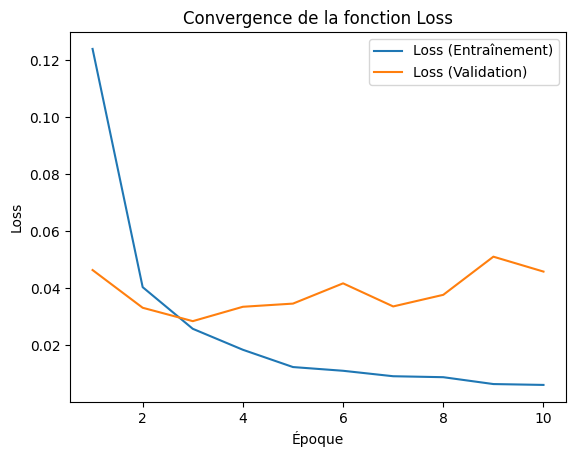

In [ ]:
# Décalage de l'axe des x : +1
epochs = range(1, len(history.history['loss']) + 1)

# Visualisation de la convergence
plt.plot(epochs, history.history['loss'], label='Loss (Entraînement)')
plt.plot(epochs, history.history['val_loss'], label='Loss (Validation)')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()
plt.title('Convergence de la fonction Loss')
plt.show()

Le graphique montre que la perte d'entraînement (courbe bleue) diminue rapidement, indiquant un apprentissage efficace. Cependant, dès une certaine époque, on observe une augmentation de la perte de validation (courbe orange), ce qui suggère le début d'un surapprentissage. Sauvegarder le modèle à ce moment précis semble être une décision judicieuse.

In [ ]:
# Trouver l'index de la plus petite valeur
index_min_val_loss = history.history['val_loss'].index(min(history.history['val_loss']))

print(f" Le modèle sauvegardé est obtenu à la {index_min_val_loss + 1}ème epoch")

 Le modèle sauvegardé est obtenu à la 3ème epoch


In [ ]:
cnn = tf.keras.models.load_model('best_model.keras')

In [ ]:
_, test_acc = cnn.evaluate(X_test, y_test,verbose=2)
print(f"Précision sur les données de test : {test_acc:.2%}")

313/313 - 1s - 4ms/step - accuracy: 0.9911 - loss: 0.0285
Précision sur les données de test : 99.11%


### B. Ablation

Dans cette partie, nous allons effectuer différentes ablations et modifications du modèle afin de tester les performances en comparaison au modèle précédent.

1. Retirons la deuxième couche de convolution

In [ ]:
# Création du modèle
model1 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Compilation du modèle
model1.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Entraînement du modèle
model1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9088 - loss: 0.3024 - val_accuracy: 0.9780 - val_loss: 0.0666
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9832 - loss: 0.0545 - val_accuracy: 0.9823 - val_loss: 0.0502
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9904 - loss: 0.0320 - val_accuracy: 0.9861 - val_loss: 0.0430
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9943 - loss: 0.0188 - val_accuracy: 0.9864 - val_loss: 0.0427
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9963 - loss: 0.0123 - val_accuracy: 0.9845 - val_loss: 0.0567
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9965 - loss: 0.0108 - val_accuracy: 0.9861 - val_loss: 0.0541
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9976 - loss: 0.0069 - val_accuracy: 0.9857 - val_loss: 0.0502
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9984 - loss: 0.0049 - 

2. Supprimons les couches de pooling

In [ ]:
# Création du modèle
model2 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Compilation du modèle
model2.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Entraînement du modèle
model2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9336 - loss: 0.2155 - val_accuracy: 0.9836 - val_loss: 0.0486
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9892 - loss: 0.0356 - val_accuracy: 0.9856 - val_loss: 0.0460
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9940 - loss: 0.0190 - val_accuracy: 0.9883 - val_loss: 0.0411
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9957 - loss: 0.0125 - val_accuracy: 0.9877 - val_loss: 0.0572
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9965 - loss: 0.0109 - val_accuracy: 0.9873 - val_loss: 0.0530
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9971 - loss: 0.0086 - val_accuracy: 0.9853 - val_loss: 0.0651
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9978 - loss: 0.0068 - val_accuracy: 0.9890 - val_loss: 0.0514
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9984 - loss: 0.005

3. Réduisons le nombre de filtres dans les couches convolutionnelles pour tester leur impact

In [ ]:
# Création du modèle
model3 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Compilation du modèle
model3.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Entraînement du modèle
model3.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9048 - loss: 0.3252 - val_accuracy: 0.9827 - val_loss: 0.0547
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9839 - loss: 0.0519 - val_accuracy: 0.9874 - val_loss: 0.0380
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9899 - loss: 0.0326 - val_accuracy: 0.9900 - val_loss: 0.0322
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9929 - loss: 0.0219 - val_accuracy: 0.9900 - val_loss: 0.0312
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9951 - loss: 0.0165 - val_accuracy: 0.9874 - val_loss: 0.0394
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9962 - loss: 0.0121 - val_accuracy: 0.9910 - val_loss: 0.0323
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9963 - loss: 0.0109 - val_accuracy: 0.9910 - val_loss: 0.0350
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9965 - loss: 0.0099 -

4. Supprimons la couche dense avec 128 neurones et observons les performances

In [ ]:
# Création du modèle
model4 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Compilation du modèle
model4.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Entraînement du modèle
model4.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8919 - loss: 0.3542 - val_accuracy: 0.9825 - val_loss: 0.0571
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9827 - loss: 0.0565 - val_accuracy: 0.9839 - val_loss: 0.0461
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9885 - loss: 0.0391 - val_accuracy: 0.9856 - val_loss: 0.0396
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9916 - loss: 0.0285 - val_accuracy: 0.9882 - val_loss: 0.0330
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9940 - loss: 0.0211 - val_accuracy: 0.9886 - val_loss: 0.0352
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9954 - loss: 0.0162 - val_accuracy: 0.9877 - val_loss: 0.0411
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9965 - loss: 0.0118 - val_accuracy: 0.9871 - val_loss: 0.0410
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9961 - loss: 0.0114 - 

5. Testons une autre fonction d'activation

In [ ]:
# Création du modèle
model5 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='tanh'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Compilation du modèle
model5.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Entraînement du modèle
model5.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9208 - loss: 0.2598 - val_accuracy: 0.9819 - val_loss: 0.0563
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9858 - loss: 0.0477 - val_accuracy: 0.9878 - val_loss: 0.0406
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9921 - loss: 0.0269 - val_accuracy: 0.9876 - val_loss: 0.0388
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9946 - loss: 0.0181 - val_accuracy: 0.9871 - val_loss: 0.0404
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9952 - loss: 0.0151 - val_accuracy: 0.9891 - val_loss: 0.0366
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9964 - loss: 0.0113 - val_accuracy: 0.9875 - val_loss: 0.0413
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9965 - loss: 0.0110 - val_accuracy: 0.9879 - val_loss: 0.0419
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9969 - loss: 0.0091 -

Lors de nos différentes simulations, nous n'avons pas obtenu de modèle avec une différence significative de résultats.

Dans un contexte où le nombre de paramètres serait important, nous aurions privilégié le modèle 3 ou 4.

Le modèle 3 comporte la même architecture que notre modèle initial mais avec un nombre de filtres réduit sur les couches de convolution.

Le modèle 4 est aussi similaire en termes d'architecture, mais la première couche dense avec 128 neurones est supprimée et permet une réduction significative du nombre de paramètres.

### C. Comparaison des résultats du modèle avec les modèles k-NN et Régresion Logistique

In [ ]:
# Aplatissement des données
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

#### k-NN

In [ ]:
# Initialisation du modèle
knn = KNeighborsClassifier(n_neighbors=5) # Nous utiliserons les 5 voisins les + proches pour nos prédictions

# Entrainement du modèle
knn.fit(X_train_flat, y_train)

# Évaluer la précision
knn_acc = knn.score(X_test_flat, y_test)
print(f"Précision k-NN : {knn_acc:.2%}")


Précision k-NN : 96.88%


#### Régression Logistique

In [ ]:
# Initialisation du modèle
log_reg = LogisticRegression(max_iter=1000)

# Entrainement du modèle
log_reg.fit(X_train_flat, y_train)

# Évaluer la précision
log_reg_acc = log_reg.score(X_test_flat, y_test)
print(f"Précision Régression Logistique : {log_reg_acc:.2%}")

Précision Régression Logistique : 92.58%


Le modèle CNN obtient la meilleure précision (99.00 %) parmi les trois pour cette comparaison initiale. Le k-NN (96.88 %) et la régression logistique (92.58 %) montrent des performances correctes, mais pourraient être limités par leur dépendance à une représentation aplatie des données.

## Partie 2 : Réponses aux questions

### Question 1 : Histogramme pour tous $x$ dans la base de validation de $m(x)$

In [ ]:
# Prédictions du modèle sur les données de test
pred_test_cnn = cnn.predict(X_test)

# Extraire la probabilité maximale pour chaque prédiction
m_x_cnn = np.max(pred_test_cnn, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


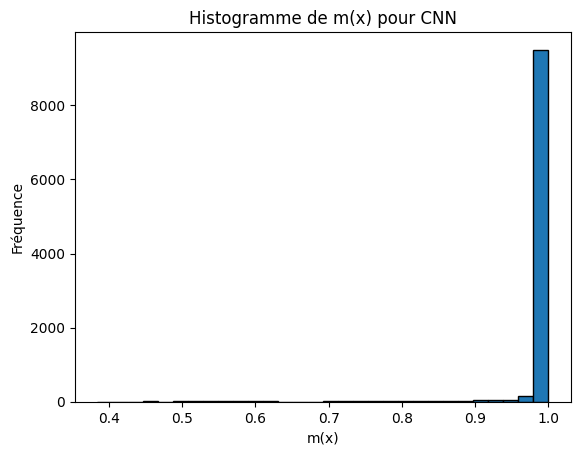

In [ ]:
# Histogramme de m(x)
plt.hist(m_x_cnn, bins=30, edgecolor='k')
plt.xlabel('m(x)')
plt.ylabel('Fréquence')
plt.title('Histogramme de m(x) pour CNN')
plt.show()

L'histogramme représente les valeurs de $m(x)$ obtenu avec un CNN, définies comme la probabilité maximale prédite par le modèle pour chaque exemple x de la base de validation. L'axe x indique les valeurs de $m(x)$ (allant de 0 à 1), et l'axe y montre la fréquence de ces valeurs. Cela permet d'évaluer la confiance du modèle dans ses prédictions.

Dans ce cas, l'histogramme montre que la plupart des valeurs de $m(x)$ sont concentrées autour de 1, ce qui signifie que le modèle est très confiant dans ses prédictions. Avec un taux d'accuracy supérieur à 98 %, cette confiance élevée est bien justifiée, reflétant une capacité solide du modèle à classifier correctement les données de test. Cette distribution confirme donc non seulement la confiance du modèle, mais aussi sa précision élevée.

### Comparaison des résultats du modèle avec les modèles k-NN et Régresion Logistique

#### k-NN

In [ ]:
# Prédictions du modèle sur les données de test
pred_test_knn = knn.predict_proba(X_test_flat)

# Extraire la probabilité maximale pour chaque prédiction
m_x_knn = np.max(pred_test_knn, axis=1)

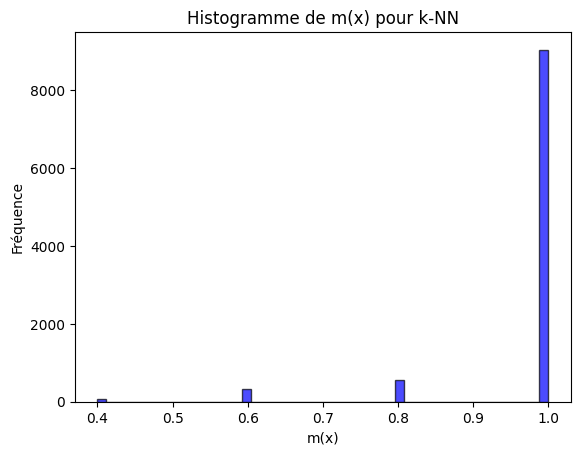

In [ ]:
# Création de l'histogramme des valeurs de m(x)
plt.hist(m_x_knn, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Histogramme de m(x) pour k-NN")
plt.xlabel("m(x)")
plt.ylabel("Fréquence")
plt.show()

L'histogramme de $m(x)$ obtenu avec k-NN montre une forte concentration à 1, mais également des pics significatifs à des valeurs inférieures, comme 0.4, 0.6, et 0.8. Ces valeurs restent discrètes en raison de l'algorithme k-NN en lui-même, qui se base uniquement sur les proportions (des voisins). Cela limite sa capacité à bien gérer les cas où les frontières entre classes sont ambiguës (par exemple un 1 et un 4), et souligne donc une moins bonne séparation des données, pour les échantillons difficiles.

#### Régression Logistique

In [ ]:
# Prédictions du modèle sur les données de test
pred_test_reg = log_reg.predict_proba(X_test_flat)

# Extraire la probabilité maximale pour chaque prédiction
m_x_reg = np.max(pred_test_reg, axis=1)

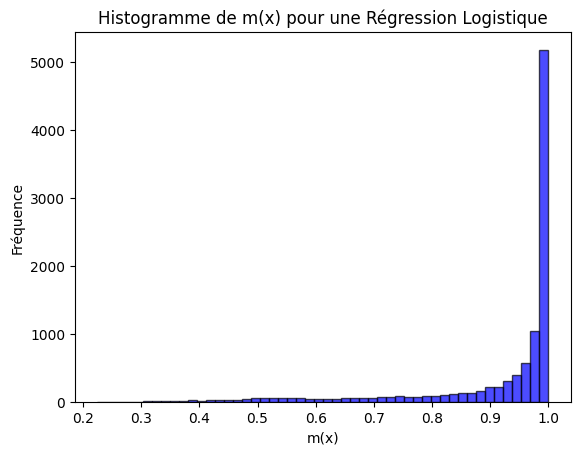

In [ ]:
# Création de l'histogramme des valeurs de m(x)
plt.hist(m_x_reg, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Histogramme de m(x) pour une Régression Logistique")
plt.xlabel("m(x)")
plt.ylabel("Fréquence")
plt.show()

L'histogramme de $m(x)$ obtenu avec la régression logistique montre une forte concentration de valeurs proches de 1, mais également une distribution plus étendue sur l'intervalle 0.2 à 0.9, contrairement à k-NN. Cela indique que la régression logistique évalue mieux les incertitudes et produit des probabilités plus continues pour les exemples ambigus.

### Question 2 : Calcul de la quantile $mq$ d'ordre $q$ de $m(x)$

In [ ]:
q_values = [0.05, 0.10, 0.25, 0.5, 0.9, 0.99]
quantiles_cnn = {q: np.quantile(m_x_cnn, q) for q in q_values}
for q, mq in quantiles_cnn.items():
    print(f"Quantile d'ordre {q}: {mq:.4f}")

Quantile d'ordre 0.05: 0.9795
Quantile d'ordre 0.1: 0.9968
Quantile d'ordre 0.25: 0.9998
Quantile d'ordre 0.5: 1.0000
Quantile d'ordre 0.9: 1.0000
Quantile d'ordre 0.99: 1.0000


In [ ]:
quantiles_cnn[0.05]

0.9795004427433014

Le calcul des différents quantiles pour CNN montre que les valeurs de $m(x)$ augmentent rapidement pour atteindre 1.0 dès q = 0.25. Cela indique que plus de 75 % des exemples sont prédits avec une confiance maximale ($m(x) = 1.0$), tandis que les 5 % inférieurs restent très proches de 1.0 (0.9949). Ce comportement renforce l'idée que le modèle fait des prédictions extrêmement nettes pour la majorité des données, avec une très faible incertitude même pour les exemples les plus difficiles.

### Comparaison des résultats du modèle avec les modèles KNN et Régresion Logistique

#### KNN

In [ ]:
quantiles_knn = {q: np.quantile(m_x_knn, q) for q in q_values}
for q, mq in quantiles_knn.items():
    print(f"Quantile d'ordre {q}: {mq:.4f}")

Quantile d'ordre 0.05: 0.8000
Quantile d'ordre 0.1: 1.0000
Quantile d'ordre 0.25: 1.0000
Quantile d'ordre 0.5: 1.0000
Quantile d'ordre 0.9: 1.0000
Quantile d'ordre 0.99: 1.0000


Le calcul des quantiles pour k-NN montre que la majorité des prédictions ont une confiance maximale, avec des valeurs de $m(x)$ égales à 1 dès le quantile 0.1. Cependant, le quantile 0.05 est à 0.8, ce qui reflète une dispersion plus marquée pour les exemples les moins confiants. Cette distribution illustre la nature discrète de k-NN, qui dépend des proportions des voisins, et montre une certaine limitation pour les cas ambigus, où la confiance est nettement réduite.

#### Régression Logistique

In [ ]:
quantiles_reg = {q: np.quantile(m_x_reg, q) for q in q_values}
for q, mq in quantiles_reg.items():
    print(f"Quantile d'ordre {q}: {mq:.4f}")

Quantile d'ordre 0.05: 0.5709
Quantile d'ordre 0.1: 0.7234
Quantile d'ordre 0.25: 0.9212
Quantile d'ordre 0.5: 0.9865
Quantile d'ordre 0.9: 0.9998
Quantile d'ordre 0.99: 1.0000


Le calcul des quantiles pour la régression logistique montre une distribution plus étendue des valeurs de $m(x)$. Le quantile 0.05 est à 0.5748, ce qui indique une confiance nettement plus faible pour certains exemples. Les quantiles augmentent progressivement jusqu'à 1 au quantile 0.99, avec une transition plus continue que pour k-NN. Cette distribution reflète la capacité de la régression logistique à gérer les incertitudes de manière plus nuancée, en attribuant des probabilités intermédiaires aux cas ambigus, tout en conservant une forte confiance pour la majorité des exemples.

### Question : Comparaison global des différents modèles

Les trois modèles (CNN, k-NN et régression logistique) ont été comparés sur leur performance à classer les données MNIST. Le modèle CNN se distingue avec une précision de 99.00 %, contre 96.88 % pour k-NN et 92.58 % pour la régression logistique. L'histogramme de $m(x)$ pour le CNN montre une très forte concentration autour de 1, illustrant une confiance extrême dans les prédictions. En revanche, k-NN présente des valeurs discrètes et moins nuancées, tandis que la régression logistique propose une distribution plus continue mais moins précise.

Le modèle CNN est le plus performant, combinant une précision élevée et une confiance nette dans ses prédictions. Ses capacités à extraire des caractéristiques complexes et à s’adapter à des données non linéaires en font le meilleur choix pour cette tâche, surpassant les autres modèles.

### Question 3 : Optimiser une image x pour maximiser une probabilité $p_i(x)$.

Pour une image $x$, nous cherchons à maximiser la probabilité associée à une classe cible $i$ :

$$\max_x p_i(x),$$

où $p_i(x)$ est la sortie associée à la classe $i$ dans le vecteur de probabilités $p(x) = \text{model}(x)$.

La mise à jour des pixels de l'image $x$ se fait par **gradient ascent** :

$$x \leftarrow x + \eta \cdot \nabla_x p_i(x),$$

où :
- $\eta$ est le taux d'apprentissage,
- $\nabla_x p_i(x)$ est le gradient de $p_i(x)$ par rapport à $x$.<br><br><br>


**Étape de Clipping**

Les valeurs des pixels d'une image doivent rester dans l'intervalle $[0, 1]$ pour représenter une image valide. Après chaque mise à jour de $x$, nous utilisons une opération de clipping pour garantir que les valeurs des pixels ne dépassent pas cette plage :

$$x \leftarrow \text{clip}(x, 0, 1).$$

En pratique, cela revient à :

- Remplacer toute valeur de pixel $x_i < 0$ par $0$,
- Remplacer toute valeur de pixel $x_i > 1$ par $1$.<br><br><br>


**1. Approche Basique**

Nous avons dans un premier temps suivi une approche "classique". La fonction perte est définie comme l'opposé de la probabilité $p_i(x)$ :

$$\text{Loss}(x) = -p_i(x).$$

Le gradient est calculé comme :

$$\nabla_x \text{Loss}(x) = -\nabla_x p_i(x),$$

et l'image est mise à jour selon :

$$x \leftarrow x - \eta \cdot \nabla_x p_i(x).$$

avec un critère d'arrêt basé sur la norme du gradient :

$$\|\nabla_x p_i(x)\| < \epsilon.$$

Le problème que nous avons renontré était que les gradients étaient très petits (proches de zéro). Cela entraînait une stagnation c'est-à-dire une absence de progression.<br><br><br>

**Apprcohe adoptée**

Pour contourner, ce problème nous avons apporté les modifications suivantes : ici, nous utilisons une perte logarithmique pour une meilleure stabilité numérique :

$$\text{Loss}(x) = -\log(p_i(x) + \epsilon),$$

où $\epsilon$ est une petite constante pour éviter les problèmes lorsque $p_i(x) \approx 0$. ($\epsilon$  = 10^(-10) )

De plus, les gradients sont normalisés pour stabiliser les mises à jour :

$$\tilde{\nabla}_x = \frac{\nabla_x \text{Loss}(x)}{\|\nabla_x \text{Loss}(x)\| + \epsilon},$$

et l'image est mise à jour par :

$$x \leftarrow x - \eta \cdot \tilde{\nabla}_x.$$

La perte utilisée garantit que la perte est bien conditionnée même si $p_i(x)$ est proche de 0. Cette fonction de perte est plus stable que l'opposé de $p_i(x)$.

La normalisation garantit que les mises à jour sont proportionnées à la direction du gradient, sans être influencées par l’amplitude du gradient.


In [ ]:
def optimize_image_cnn(model, initial_image, target_class, target_prob, learning_rate=1, max_iterations=500):
    """
    Optimise une image pour maximiser la probabilité d'une classe cible.

    Args:
        model: le modèle CNN entraîné
        initial_image: l'image de départ
        target_class: la classe cible (0-9)
        target_prob: la probabilité cible à atteindre
        learning_rate: taux d'apprentissage pour l'optimisation
        max_iterations: nombre maximum d'itérations
    """
    # Convertir l'image initiale en Variable TensorFlow
    image = tf.Variable(initial_image, dtype=tf.float32)

    # Garder trace des probabilités pour visualisation
    probs_history = []

    # Optimisation
    for i in range(max_iterations):
        with tf.GradientTape() as tape:
            # Ajouter dimension batch et obtenir prédictions
            predictions = model(tf.expand_dims(image, 0))
            # Loss: négative log probability pour la classe cible
            loss = -tf.math.log(predictions[0, target_class] + 1e-10)

        # Calculer gradients
        gradients = tape.gradient(loss, image)

        # Normaliser les gradients
        gradients = gradients / (tf.norm(gradients) + 1e-10)

        # Mettre à jour l'image
        image.assign_sub(learning_rate * gradients)

        # Clipper les valeurs entre 0 et 1
        image.assign(tf.clip_by_value(image, 0, 1))

        # Obtenir la probabilité actuelle
        current_prob = model(tf.expand_dims(image, 0))[0, target_class].numpy()
        probs_history.append(current_prob)

        # Afficher le progrès toutes les 50 itérations
        if i % 50 == 0:
            print(f"Iteration {i}, Probabilité pour classe {target_class}: {current_prob:.4f}")

        # Critère d'arrêt
        if current_prob >= target_prob:
            print(f"Succès! Probabilité cible atteinte en {i} itérations")
            break
    return image.numpy(), probs_history

### Question 4 : Dessinez le resultat pour plusieurs choix initiaux.

In [ ]:
def visualize_image_optimization(model, X_test, optimize_function, learning_rate, max_iter, quantiles=[0.5, 0.9, 0.99]):
  """
    Visualise l'optimisation d'une image dans X_test pour plusieurs quantiles.

    Args:
        model: Le modèle utilisé.
        X_test: Les données de test.
        optimize_function: La fonction d'optimisation associée au modèle.
        model_type: Le type de modèle ('cnn', 'knn', 'logistic').
        mq: Paramètre utilisé dans la fonction d'optimisation (si applicable).
        quantiles: Liste des quantiles à tester (par défaut [0.5, 0.9, 0.99]).

    Returns:
        None
    """
  for q in quantiles:
    # Sélectionner une image aléatoire dans X_test
    idx = np.random.randint(len(X_test))
    x0 = X_test[idx]

    # Obtenir la classe réelle de l'image
    true_class = y_test[idx]

    # Choisir une classe cible différente de la classe réelle
    target_class = true_class
    while target_class == true_class:
      target_class = np.random.randint(10)  # Choisir une classe cible aléatoire entre 0 et 9

    print(f"Quantile cible : {q} | Probabilité cible : {quantiles_cnn[q]:.4f} | Classe cible sélectionnée : {target_class}")


    # Obtenir la probabilité initiale pour CNN
    preds = model.predict(x0[np.newaxis, ...])
    initial_prob = preds[0, target_class]
    print(f"Probabilité initiale pour la classe {target_class} : {initial_prob:.4f}")

    # Optimiser l'image
    optimized_x, probs_history = optimize_function(model, x0, target_class, quantiles_cnn[q], learning_rate=learning_rate, max_iterations=max_iter)

    # Obtenir la probabilité optimisée
    optimized_preds = model.predict(optimized_x[np.newaxis, ...])
    optimized_prob = optimized_preds[0, target_class]

    print(f"Probabilité optimisée pour la classe {target_class} : {optimized_prob:.4f}")

    # Créer un subplot 2x2
    fig = plt.figure(figsize=(10, 8))

    # Afficher l'image initiale
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.imshow(x0.reshape(28, 28), cmap='gray')
    ax1.set_title(f"Image initiale\nProba cible: {initial_prob:.4f}")
    ax1.axis('off')

    # Afficher l'image optimisée
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.imshow(optimized_x.reshape(28, 28), cmap='gray')
    ax2.set_title(f"Image optimisée\nProba cible: {optimized_prob:.4f}")
    ax2.axis('off')

    # Tracer l'évolution de la probabilité
    ax3 = fig.add_subplot(2, 2, (3, 4))
    ax3.plot(probs_history)
    ax3.set_title(f'Evolution de la probabilité pour la classe {target_class}')
    ax3.set_xlabel('Itération')
    ax3.set_ylabel('Probabilité')
    ax3.grid(True)

    # Ajouter un titre général
    plt.suptitle(f"Quantile : {q} | Classe cible : {target_class}", fontsize=14)
    plt.tight_layout()
    plt.show()

Quantile cible : 0.05 | Probabilité cible : 0.9795 | Classe cible sélectionnée : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
Probabilité initiale pour la classe 2 : 0.0000
Iteration 0, Probabilité pour classe 2: 0.0000
Iteration 50, Probabilité pour classe 2: 0.0000
Iteration 100, Probabilité pour classe 2: 0.0000
Iteration 150, Probabilité pour classe 2: 0.0006
Iteration 200, Probabilité pour classe 2: 0.0098
Iteration 250, Probabilité pour classe 2: 0.1747
Iteration 300, Probabilité pour classe 2: 0.7969
Succès! Probabilité cible atteinte en 348 itérations
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Probabilité optimisée pour la classe 2 : 0.9799


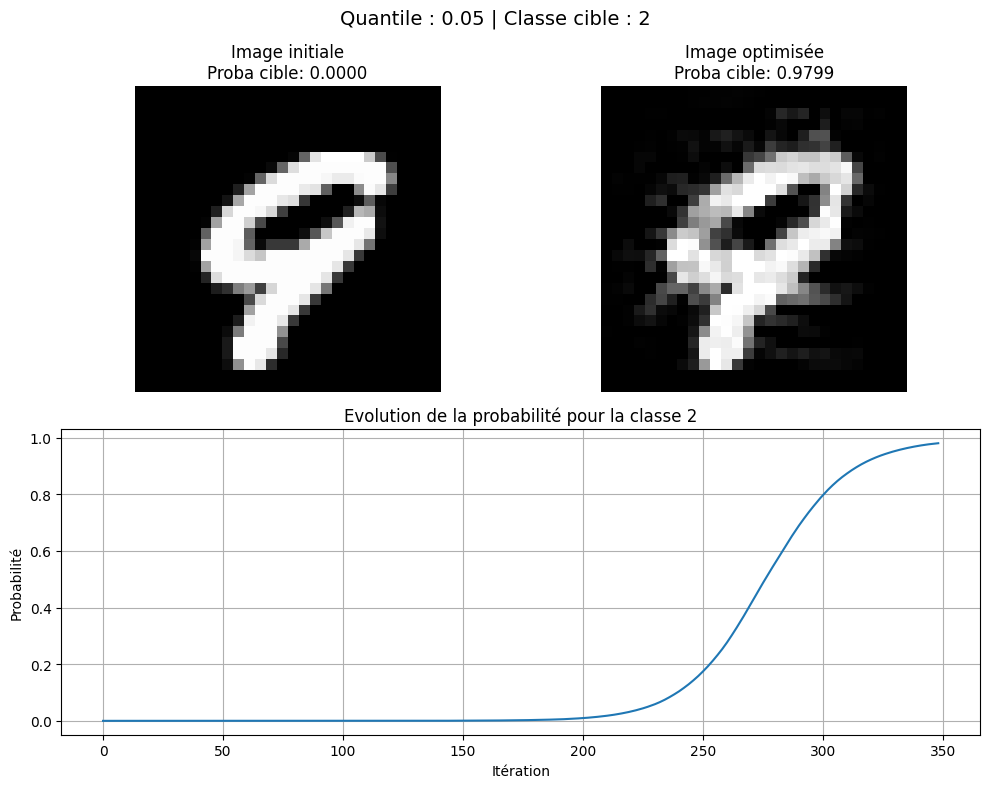

Quantile cible : 0.1 | Probabilité cible : 0.9968 | Classe cible sélectionnée : 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Probabilité initiale pour la classe 0 : 0.0000
Iteration 0, Probabilité pour classe 0: 0.0000
Iteration 50, Probabilité pour classe 0: 0.0000
Iteration 100, Probabilité pour classe 0: 0.0000
Iteration 150, Probabilité pour classe 0: 0.0000
Iteration 200, Probabilité pour classe 0: 0.0000
Iteration 250, Probabilité pour classe 0: 0.0009
Iteration 300, Probabilité pour classe 0: 0.0120
Iteration 350, Probabilité pour classe 0: 0.1035
Iteration 400, Probabilité pour classe 0: 0.4507
Iteration 450, Probabilité pour classe 0: 0.8635
Iteration 500, Probabilité pour classe 0: 0.9654
Iteration 550, Probabilité pour classe 0: 0.9884
Iteration 600, Probabilité pour classe 0: 0.9954
Succès! Probabilité cible atteinte en 623 itérations
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Probabilité optimisée pour la classe 0 : 0.9968


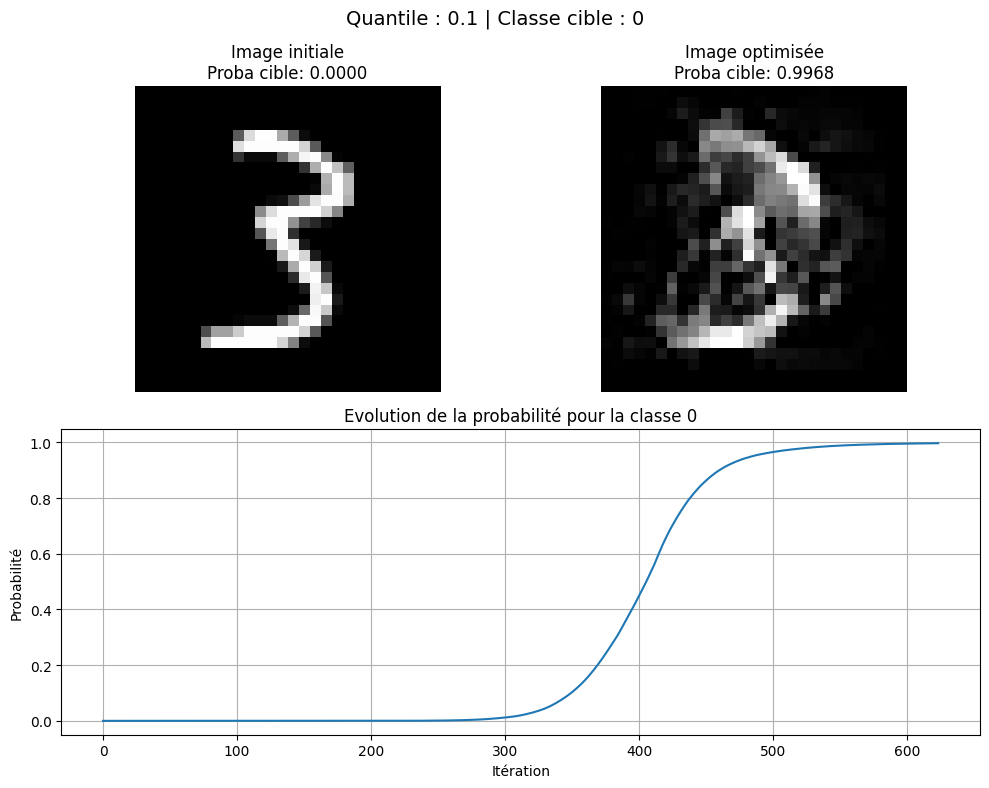

Quantile cible : 0.25 | Probabilité cible : 0.9998 | Classe cible sélectionnée : 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Probabilité initiale pour la classe 8 : 0.0000
Iteration 0, Probabilité pour classe 8: 0.0000
Iteration 50, Probabilité pour classe 8: 0.0000
Iteration 100, Probabilité pour classe 8: 0.0000
Iteration 150, Probabilité pour classe 8: 0.0001
Iteration 200, Probabilité pour classe 8: 0.0092
Iteration 250, Probabilité pour classe 8: 0.3158
Iteration 300, Probabilité pour classe 8: 0.9520
Iteration 350, Probabilité pour classe 8: 0.9977
Succès! Probabilité cible atteinte en 397 itérations
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Probabilité optimisée pour la classe 8 : 0.9998


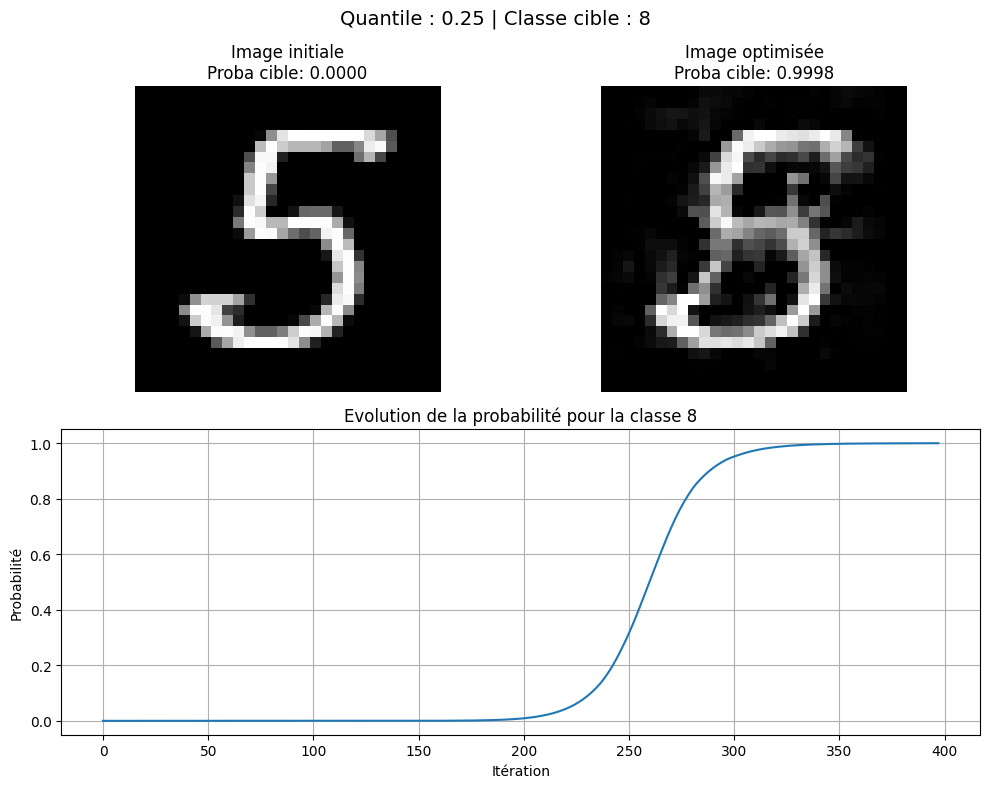

In [ ]:
visualize_image_optimization(cnn, X_test, optimize_image_cnn, 0.01, 10000, [0.05, 0.1, 0.25])

L'optimisation d'une image via un CNN repose sur un ajustement progressif des pixels pour maximiser la probabilité d'une classe cible. Le choix du taux d'apprentissage (learning rate) est crucial pour garantir la convergence vers la probabilité souhaitée.

Un taux d'apprentissage trop élevé peut entraîner des mises à jour trop brutales, rendant l'optimisation instable et empêchant le modèle d'atteindre la probabilité cible. Cela peut provoquer des oscillations autour de la solution optimale ou même l'échec de l'optimisation.

À l'inverse, un taux d'apprentissage trop faible conduit à des mises à jour trop lentes, augmentant considérablement le nombre d'itérations nécessaires pour atteindre la probabilité cible.

# Question bonus : Optimisation via k-NN

# Optimisation d’une image via k-NN

## 1. Maximisation de la probabilité prédisant la classe

Dans le cas précédent d’un réseau de neurones , la fonction $p_i(x)$ désignait directement la probabilité prédisant la classe $i$ pour l’image $x$.

Dans le cas du k-NN, nous définissons une "pseudo-probabilité", $p_i(x)$ comme étant la fraction de voisins (parmi les $k$ plus proches voisins) qui appartiennent à la classe $i$.

Autrement dit :

$$
p_i(x) = \frac{\text{nbr de voisins dont la classe est } i}{k}.
$$

Nous cherchons à optimiser $x$ de manière à maximiser $p_i(x)$, i.e $$
\max_x p_i(x).
$$

## 2. La mise à jour de $ x $

Contrairement au réseau de neurones, la fonction $p_i(x)$ du k-NN n’est pas différentiable au sens classique, car $p_i(x)$ dépend de la distance entre $x$ et chaque point d’entraînement.

Cependant, nous pouvons approximer la direction où augemente $p_i(x)$ en nous basant sur la position des plus proches voisins de $x$.

### Processus de mise à jour

#### 1. Calcul des plus proches voisins  
À chaque itération, nous identifions l’ensemble des $k$ plus proches voisins de notre image (vecteur) $x$, notons leurs indices :  $ \{n_1, n_2, \dots, n_k\}.$

#### 2. Estimation de $p_i(x)$  

La fraction  
$$
\frac{\text{nombre de voisins de classe } i}{k}
$$  
nous indique la probabilité courante $p_i(x)$.

Si $p_i(x)$ atteint déjà la valeur cible (ou dépasse un certain seuil), nous pouvons stopper l’optimisation.

#### 3. Approximation du "gradient"  
Même si $p_i(x)$ n’est pas différentiable, on peut chercher une direction dans laquelle déplacer $x$ pour se rapprocher des voisin qui sont dans la classe $i$.  

En pratique, on peut par exemple sommer les vecteurs $ (x - X^{(n_j)}_{\text{train}}) $ pour chacun des $ k $ voisins (ou uniquement ceux qui ne sont pas de la classe $ i $), afin d’obtenir une direction moyenne qui éloigne $ x $ de ces points-là et le rapproche potentiellement de ceux de la classe cible.  

On définit ensuite une MAJ de la forme :  
$$
x \leftarrow x - \eta \cdot \text{direction},
$$  
où $ \eta$ est le taux d’apprentissage.


## 3. Critères d’arrêt

### 1. Seuil de probabilité  
Comme pour le CNN, nous pouvons arrêter le processus dès que :  
$$
p_i(x) \geq \text{seuil}.
$$

### 2. Nombre maximum d’itérations  
Pour éviter une boucle infinie, on fixe également un nombre maximal d’itérations.

#### 3. Masque aléatoire  
Pour éviter de modifier tous les pixels de manière simultanée, on peut appliquer un masque aléatoire sur les MAJ, c’est-à-dire ne mettre à jour qu’un certain pourcentage de composantes de $ x $ à chaque itération. Pour éviter les problèmes de minima locaux que nous avons rencontrés précédemment.




In [ ]:
def optimize_x_knn(x0, target_label, model, threshold, max_iter=1000, lr=0.1):
    x = x0.copy()
    for _ in range(max_iter):
        # Trouver les voisins les plus proches
        neighbors = model.kneighbors(x.reshape(1, -1), return_distance=False)
        neighbor_labels = y_train[neighbors[0]]

        # Calcul de p_i(x)
        counts = np.bincount(neighbor_labels, minlength=10)
        p_i_x = counts[target_label] / neighbors.shape[1]

        if p_i_x >= threshold:
            break

        # Approximation du "gradient"
        gradient = np.zeros_like(x)
        for idx in neighbors[0]:
            diff = x - X_train_flat[idx]
            gradient += diff
        gradient /= len(neighbors[0]) # en moyenne

        # Masque aléatoire
        mask = np.random.choice([0, 1], size=x.shape, p=[0.9, 0.1])
        x += lr * gradient * mask

    return x

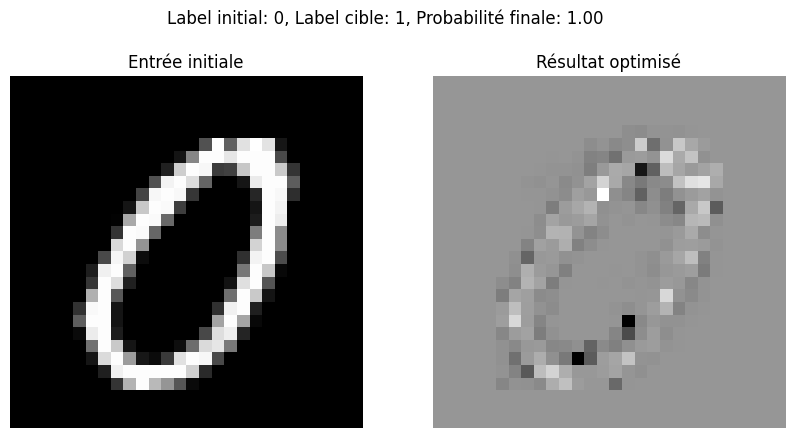

In [ ]:
# Sélection d'une image de test # 1 minute
idx = np.random.randint(len(X_test_flat))  # Sélection d'une image aléatoire
x0 = X_test_flat[idx]  # Image initiale

# Choix d'une classe cible
target_label = np.random.randint(10)  # Classe cible choisie aléatoirement

# Prédiction initiale pour obtenir le label initial
neighbors_initial = knn.kneighbors(x0.reshape(1, -1), return_distance=False)
neighbor_labels_initial = y_train[neighbors_initial[0]]
initial_label = np.argmax(np.bincount(neighbor_labels_initial))  # Classe prédite initialement

# Optimisation de l'image
threshold = 1.0  # Probabilité cible à atteindre
optimized_x = optimize_x_knn(x0, target_label, knn, 1)

# Prédiction après optimisation pour afficher la probabilité finale
neighbors_optimized = knn.kneighbors(optimized_x.reshape(1, -1), return_distance=False)
neighbor_labels_optimized = y_train[neighbors_optimized[0]]
final_prob = np.max(np.bincount(neighbor_labels_optimized) / len(neighbor_labels_optimized))

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Création figure avec 2 sous-graphes
axes[0].imshow(x0.reshape(28, 28), cmap='gray')  # Affichage de l'image initiale
axes[0].set_title("Entrée initiale")
axes[0].axis('off')

axes[1].imshow(optimized_x.reshape(28, 28), cmap='gray')  # Affichage de l'image optimisée
axes[1].set_title("Résultat optimisé")
axes[1].axis('off')

# Ajouter un titre global avec le label initial, la classe cible, et la probabilité finale
plt.suptitle(f"Label initial: {initial_label}, Label cible: {target_label}, Probabilité finale: {final_prob:.2f}")
plt.show()

### Analyse de l'optimisation

#### Résultats obtenus via k-NN
L’optimisation via k-NN repose sur l’ajustement de l’image en fonction des voisins les plus proches. Cependant, les résultats montrent rapidement les limites de cette méthode.

L’image optimisée est floue et n’affiche pas clairement les traits caractéristiques de la classe cible, ici le 9. Bien que la probabilité associée à cette classe atteigne 0.60, l’optimisation reste largement inefficace pour produire une image reconnaissable. Ces résultats s’expliquent par l’absence de gradients, au lieu de calculs précis, les ajustements sont approximés à partir des différences avec les voisins => des modifications dispersées et incohérentes.

De plus, le processus est particulièrement coûteux, car chaque itération nécessite de recalculer les distances entre l’image en cours d’optimisation et toutes les données d’entraînement.

#### Comparaison avec CNN
L’optimisation via CNN donne des résultats bien plus convaincants. L’image optimisée présente des traits plus structurés et proches de la classe cible, même si la probabilité finale est légèrement inférieure (0.5065 contre 0.60 pour k-NN). Contrairement à k-NN, le CNN utilise des gradients, ce qui rend l’optimisation plus cohérente.

De plus, le CNN est nettement plus rapide dans son exécution, il n’a pas besoin de recalculer des distances à chaque itération, ce qui simplifie le processus et le rend bien plus efficace.

#### Conclusion
Ces résultats confirment les limites de k-NN : bien qu’il atteigne une probabilité acceptable pour la classe cible, l’image optimisée reste incohérente, contrairement au CNN.


# Pistes d'exploration et perspectives d'amélioration

Nous avons mené à bien tout ce qui était attendu dans ce projet, en explorant différentes approches et en atteignant les objectifs fixés. Ce travail a posé des bases solides, mais il ouvre également la voie à de nombreuses opportunités pour aller plus loin. Ces pistes d’exploration pourraient enrichir les analyses, améliorer les performances des modèles et élargir leurs applications à des problématiques plus variées.

Un premier axe à approfondir concerne la comparaison avec d'autres modèles. Il pourrait être intéressant d'étudier des algorithmes tels que les SVM ou les arbres voir les forets, pour évaluer leur robustesse, précision et vitesse d'exécution sur des tâches similaires.

Ensuite, tester notre méthode sur d'autres jeux de données, comme CIFAR-10 ou F-MNIST, serait une bonne manière d'évaluer leur capacité à s'adapter à des données plus complexes ou d'un autre type. Cela permettrait également de voir comment les modèles se comportent lorsque la quantité ou la nature des données change, pour juger de la polyvalence globale du modèle.

Il serait aussi intéressant d'étudier la robustesse des modèles face à des perturbations, comme l'ajout de bruit ou des modifications dans les données d'entrée pour vérifier si le modèle reste fiable dans des conditions moins idéales.

Enfin, une piste motivante serait d'adapter ces approches à des applications plus concrètes de la vie de tous les jours, notamment à l'université, comme la reconnaissance d'écriture manuscrite de certains enseignants, dont les écritures au tableau, annotations ou les copies corrigées ne sont pas toujours faciles à lire ... (cf Calcul Stochastique).